In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sythrad2023-brain/processed/patient_split.json
/kaggle/input/sythrad2023-brain/processed/CT_slices/1BB205_axial_slice_111.npy
/kaggle/input/sythrad2023-brain/processed/CT_slices/1BA201_axial_slice_128.npy
/kaggle/input/sythrad2023-brain/processed/CT_slices/1BC014_axial_slice_086.npy
/kaggle/input/sythrad2023-brain/processed/CT_slices/1BA001_axial_slice_125.npy
/kaggle/input/sythrad2023-brain/processed/CT_slices/1BC041_axial_slice_074.npy
/kaggle/input/sythrad2023-brain/processed/CT_slices/1BB041_axial_slice_072.npy
/kaggle/input/sythrad2023-brain/processed/CT_slices/1BB007_axial_slice_078.npy
/kaggle/input/sythrad2023-brain/processed/CT_slices/1BC083_axial_slice_085.npy
/kaggle/input/sythrad2023-brain/processed/CT_slices/1BC064_axial_slice_091.npy
/kaggle/input/sythrad2023-brain/processed/CT_slices/1BB051_axial_slice_053.npy
/kaggle/input/sythrad2023-brain/processed/CT_slices/1BB011_axial_slice_091.npy
/kaggle/input/sythrad2023-brain/processed/CT_slices/1BA185_axial_slice

Using device: cuda
Train=3780, Val=540, Test=1080


Epoch 5: 100%|██████████| 60/60 [01:09<00:00,  1.15s/it]


Val5: SSIM=0.6872, MAE=0.075


Epoch 10: 100%|██████████| 60/60 [01:03<00:00,  1.06s/it]


Val10: SSIM=0.3735, MAE=0.253


Epoch 15: 100%|██████████| 60/60 [01:04<00:00,  1.08s/it]


Val15: SSIM=0.7530, MAE=0.056


Epoch 20: 100%|██████████| 60/60 [01:04<00:00,  1.08s/it]


Val20: SSIM=0.7171, MAE=0.071


Epoch 25: 100%|██████████| 60/60 [01:06<00:00,  1.11s/it]


Val25: SSIM=0.7360, MAE=0.063


Epoch 30: 100%|██████████| 60/60 [01:04<00:00,  1.08s/it]


Val30: SSIM=0.6314, MAE=0.086


Epoch 35: 100%|██████████| 60/60 [01:05<00:00,  1.09s/it]


Val35: SSIM=0.7925, MAE=0.052


Epoch 40: 100%|██████████| 60/60 [01:05<00:00,  1.08s/it]


Val40: SSIM=0.8005, MAE=0.048


Epoch 45: 100%|██████████| 60/60 [01:04<00:00,  1.07s/it]


Val45: SSIM=0.6587, MAE=0.083


Epoch 50: 100%|██████████| 60/60 [01:04<00:00,  1.07s/it]


Val50: SSIM=0.7740, MAE=0.053


Epoch 55: 100%|██████████| 60/60 [01:04<00:00,  1.07s/it]


Val55: SSIM=0.7882, MAE=0.051


Epoch 60: 100%|██████████| 60/60 [01:04<00:00,  1.07s/it]


Val60: SSIM=0.7718, MAE=0.055


Epoch 65: 100%|██████████| 60/60 [01:04<00:00,  1.07s/it]


Val65: SSIM=0.6782, MAE=0.076


Epoch 70: 100%|██████████| 60/60 [01:04<00:00,  1.07s/it]


Val70: SSIM=0.7949, MAE=0.050


Epoch 75: 100%|██████████| 60/60 [01:05<00:00,  1.09s/it]


Val75: SSIM=0.6813, MAE=0.080


Epoch 80: 100%|██████████| 60/60 [01:04<00:00,  1.07s/it]


Val80: SSIM=0.7805, MAE=0.052
Testing with /kaggle/working/PIX2PIX_turbo/netG_epoch40.pth
Testing complete, results saved


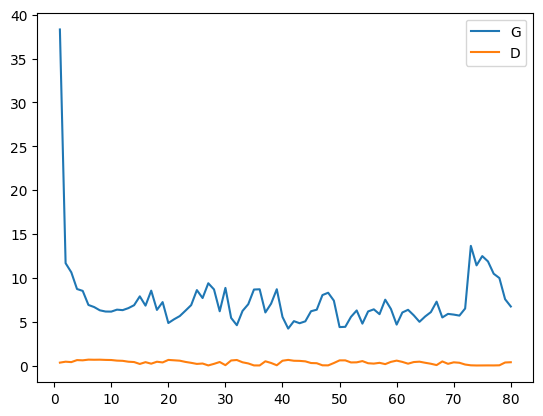

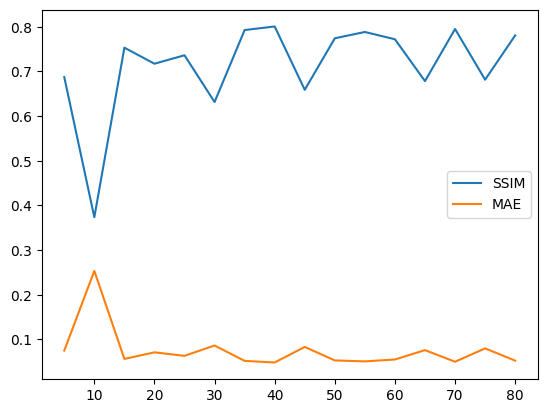

In [2]:
"""
Pix2Pix-Turbo Training Pipeline (Unified)
MRI → CT synthesis with patient-based splits
- Dataset: patient_splits.json + MRI/CT slice dirs
- Training: GAN + L1
- Validation: PSNR & SSIM, save grids
- Logs: CSV + plots
- Keep top-5 models by SSIM
- Testing: per-patient summary PNGs + Excel metrics
"""

import os, json
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.utils as vutils
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import matplotlib.pyplot as plt

# -------------------------
# Config
# -------------------------
class Config:
    data_root = "/kaggle/input/sythrad2023-brain/processed"
    batch_size = 64
    num_epochs = 80
    lr = 2e-4
    beta1 = 0.5
    image_size = 256
    validate_every = 5
    sample_grid_n = 4
    max_val_batches = 50
    save_dir = "/kaggle/working/PIX2PIX_turbo"
    top_k = 5
    hu_min, hu_max = -1000, 2000

cfg = Config()
os.makedirs(cfg.save_dir, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------
# Dataset
# -------------------------
class MRICtDataset(Dataset):
    def __init__(self, split, split_json, mri_dir, ct_dir, image_size=256):
        with open(split_json, "r") as f:
            splits = json.load(f)

        key_map = {"train": "train_patients", "val": "val_patients", "test": "test_patients"}
        patient_ids = splits[key_map[split]]

        all_mri_files = sorted(os.listdir(mri_dir))
        self.files = [f for f in all_mri_files if any(pid in f for pid in patient_ids)]

        self.mri_dir, self.ct_dir = mri_dir, ct_dir

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]

        # load slices (already float32, [-1,1], 256x256)
        mri_slice = np.load(os.path.join(self.mri_dir, fname)).astype(np.float32)
        ct_slice  = np.load(os.path.join(self.ct_dir, fname)).astype(np.float32)

        # add channel if grayscale
        if mri_slice.ndim == 2: mri_slice = np.expand_dims(mri_slice, -1)
        if ct_slice.ndim == 2:  ct_slice  = np.expand_dims(ct_slice, -1)

        # convert to tensor, permute HWC -> CHW
        mri = torch.from_numpy(mri_slice).permute(2,0,1)
        ct  = torch.from_numpy(ct_slice).permute(2,0,1)

        # return with patient_id and filename
        return mri, ct, str(fname.split("_")[0]), str(fname)

# -------------------------
# Data
# -------------------------
split_json = os.path.join(cfg.data_root, "patient_split.json")
mri_dir    = os.path.join(cfg.data_root, "MRI_slices")
ct_dir     = os.path.join(cfg.data_root, "CT_slices")

train_ds = MRICtDataset("train", split_json, mri_dir, ct_dir, cfg.image_size)
val_ds   = MRICtDataset("val", split_json, mri_dir, ct_dir, cfg.image_size)
test_ds  = MRICtDataset("test", split_json, mri_dir, ct_dir, cfg.image_size)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=True, pin_memory=True)

print(f"Train={len(train_ds)}, Val={len(val_ds)}, Test={len(test_ds)}")

# -------------------------
# Models
# -------------------------
class UNetGenerator(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base=64):
        super().__init__()
        def down(in_c, out_c, bn=True):
            layers = [nn.Conv2d(in_c, out_c, 4, 2, 1)]
            if bn: layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        def up(in_c, out_c, dropout=False):
            layers = [nn.ConvTranspose2d(in_c, out_c, 4, 2, 1),
                      nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)]
            if dropout: layers.append(nn.Dropout(0.5))
            return nn.Sequential(*layers)

        self.down1 = down(in_ch, base, bn=False)
        self.down2 = down(base, base*2)
        self.down3 = down(base*2, base*4)
        self.down4 = down(base*4, base*8)
        self.down5 = down(base*8, base*8)
        self.down6 = down(base*8, base*8)
        self.down7 = down(base*8, base*8)
        self.down8 = down(base*8, base*8, bn=False)

        self.up1 = up(base*8, base*8, dropout=True)
        self.up2 = up(base*16, base*8, dropout=True)
        self.up3 = up(base*16, base*8, dropout=True)
        self.up4 = up(base*16, base*8)
        self.up5 = up(base*16, base*4)
        self.up6 = up(base*8, base*2)
        self.up7 = up(base*4, base)
        self.final = nn.Sequential(nn.ConvTranspose2d(base*2, out_ch, 4, 2, 1), nn.Tanh())

    def forward(self, x):
        d1 = self.down1(x); d2 = self.down2(d1); d3 = self.down3(d2)
        d4 = self.down4(d3); d5 = self.down5(d4); d6 = self.down6(d5)
        d7 = self.down7(d6); bn = self.down8(d7)
        u1 = self.up1(bn); u2 = self.up2(torch.cat([u1,d7],1))
        u3 = self.up3(torch.cat([u2,d6],1)); u4 = self.up4(torch.cat([u3,d5],1))
        u5 = self.up5(torch.cat([u4,d4],1)); u6 = self.up6(torch.cat([u5,d3],1))
        u7 = self.up7(torch.cat([u6,d2],1)); return self.final(torch.cat([u7,d1],1))

class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=2, base=64):
        super().__init__()
        def block(in_c, out_c, s=2, bn=True):
            layers = [nn.Conv2d(in_c, out_c, 4, s, 1)]
            if bn: layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)
        self.model = nn.Sequential(
            block(in_ch, base, bn=False),
            block(base, base*2),
            block(base*2, base*4),
            block(base*4, base*8, s=1),
            nn.Conv2d(base*8, 1, 4, 1, 1)
        )
    def forward(self, x, y): return self.model(torch.cat([x,y],1))

# -------------------------
# Metrics
# -------------------------
def compute_metrics(fake, real):
    f = fake.squeeze().cpu().numpy()
    r = real.squeeze().cpu().numpy()
    ssim = structural_similarity(r, f, data_range=2.0)
    psnr = peak_signal_noise_ratio(r, f, data_range=2.0)
    mae = np.mean(np.abs(r-f))
    mse = np.mean((r-f)**2)
    return ssim, psnr, mae, mse

# -------------------------
# Train / Validate / Test
# -------------------------
def train():
    G, D = UNetGenerator().to(device), PatchDiscriminator().to(device)
    optG = optim.Adam(G.parameters(), lr=cfg.lr, betas=(cfg.beta1, 0.999))
    optD = optim.Adam(D.parameters(), lr=cfg.lr, betas=(cfg.beta1, 0.999))
    bce, l1 = nn.BCEWithLogitsLoss(), nn.L1Loss()

    best_models, val_history = [], []
    train_log = {"epoch": [], "loss_G": [], "loss_D": []}

    for epoch in range(cfg.num_epochs):
        G.train(); D.train()
        loss_G_epoch, loss_D_epoch = [], []
        for mri, ct, _, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            mri, ct = mri.to(device), ct.to(device)

            # Train D
            fake = G(mri)
            pred_real = D(mri, ct); pred_fake = D(mri, fake.detach())
            loss_real = bce(pred_real, torch.ones_like(pred_real))
            loss_fake = bce(pred_fake, torch.zeros_like(pred_fake))
            loss_D = 0.5*(loss_real+loss_fake)
            optD.zero_grad(); loss_D.backward(); optD.step()

            # Train G
            pred_fake = D(mri, fake)
            loss_GAN = bce(pred_fake, torch.ones_like(pred_fake))
            loss_L1 = l1(fake, ct)*100.0
            loss_G = loss_GAN + loss_L1
            optG.zero_grad(); loss_G.backward(); optG.step()

            loss_D_epoch.append(loss_D.item()); loss_G_epoch.append(loss_G.item())

        # log
        train_log["epoch"].append(epoch+1)
        train_log["loss_G"].append(np.mean(loss_G_epoch))
        train_log["loss_D"].append(np.mean(loss_D_epoch))

        # validate
        if (epoch+1) % cfg.validate_every == 0:
            G.eval(); metrics=[]
            with torch.no_grad():
                for i,(mri,ct,_,_) in enumerate(val_loader):
                    fake=G(mri.to(device)); metrics.append(compute_metrics(fake, ct))
                    if cfg.max_val_batches and (i+1>=cfg.max_val_batches): break
            ssim, psnr, mae, mse = np.mean(metrics,0)
            print(f"Val{epoch+1}: SSIM={ssim:.4f}, MAE={mae:.3f}")
            val_history.append({"epoch":epoch+1,"ssim":ssim,"psnr":psnr,"mae":mae,"mse":mse})

            # save sample grid
            samples=[]
            for i,(mri,ct,_,_) in enumerate(val_loader):
                fake=G(mri.to(device)); err=torch.abs(fake-ct.to(device))
                grid=vutils.make_grid([mri[0],fake[0].cpu(),ct[0],err[0].cpu()],
                                      nrow=4,normalize=True,value_range=(-1,1))
                samples.append(grid); 
                if len(samples)>=cfg.sample_grid_n: break
            if samples:
                summary=torch.cat(samples,dim=1)
                vutils.save_image(summary, os.path.join(cfg.save_dir,f"val_epoch{epoch+1}.png"))

            # save model
            model_path=os.path.join(cfg.save_dir,f"netG_epoch{epoch+1}.pth")
            torch.save(G.state_dict(),model_path)
            best_models.append((ssim,model_path))
            best_models=sorted(best_models,key=lambda x:x[0],reverse=True)[:cfg.top_k]

    # save logs
    pd.DataFrame(train_log).to_csv(os.path.join(cfg.save_dir,"train_history.csv"),index=False)
    pd.DataFrame(val_history).to_csv(os.path.join(cfg.save_dir,"val_history.csv"),index=False)

    # plots
    plt.figure(); plt.plot(train_log["epoch"],train_log["loss_G"],label="G")
    plt.plot(train_log["epoch"],train_log["loss_D"],label="D"); plt.legend()
    plt.savefig(os.path.join(cfg.save_dir,"training_losses.png"))

    val_df=pd.DataFrame(val_history)
    if len(val_df)>0:
        plt.figure(); plt.plot(val_df["epoch"],val_df["ssim"],label="SSIM")
        plt.plot(val_df["epoch"],val_df["mae"],label="MAE"); plt.legend()
        plt.savefig(os.path.join(cfg.save_dir,"val_metrics.png"))

    # testing with best model
    best_ssim, path = best_models[0]
    print(f"Testing with {path}")
    G.load_state_dict(torch.load(path, map_location=device))
    G.eval()

    patient_data = {}
    for mri, ct, pid, fname in test_loader:
        pid, fname = pid[0], fname[0]  # string scalars
        if pid not in patient_data:
            patient_data[pid] = []
        patient_data[pid].append((mri, ct, fname))

    test_metrics = []

    with torch.no_grad():
        for pid, slices in patient_data.items():
            # pick 10 slices (spread evenly if >10, else all)
            if len(slices) > 10:
                idxs = np.linspace(0, len(slices) - 1, 10, dtype=int)
            else:
                idxs = list(range(len(slices)))

            rows, patient_scores = [], []
            for idx in idxs:
                mri, ct, fname = slices[idx]
                mri, ct = mri.to(device), ct.to(device)

                fake = G(mri)
                ssim, psnr, mae, mse = compute_metrics(fake, ct)
                patient_scores.append([ssim, psnr, mae, mse])

                # visualization
                err = torch.abs(fake - ct)
                grid = vutils.make_grid([mri[0], fake[0], ct[0], err[0]],
                                        nrow=4, normalize=True, value_range=(-1, 1))
                rows.append(grid)

            # average over selected slices
            patient_scores = np.mean(patient_scores, axis=0)
            test_metrics.append({
                "patient": pid,
                "ssim": patient_scores[0],
                "psnr": patient_scores[1],
                "mae": patient_scores[2],
                "mse": patient_scores[3]
            })

            # save summary visualization
            summary = torch.cat(rows, dim=1)
            vutils.save_image(summary, os.path.join(cfg.save_dir, f"{pid}_summary.png"))

    # save patient-level metrics
    df = pd.DataFrame(test_metrics)

    # add overall average row
    avg_row = {
        "patient": "Overall_Avg",
        "ssim": df["ssim"].mean(),
        "psnr": df["psnr"].mean(),
        "mae": df["mae"].mean(),
        "mse": df["mse"].mean()
    }
    df = pd.concat([df, pd.DataFrame([avg_row])], ignore_index=True)

    df.to_excel(os.path.join(cfg.save_dir, "test_metrics.xlsx"), index=False)
    print("Testing complete, results saved")


if __name__=="__main__":
    train()
